# Exercise 2

**(1)** Test for model mis-specification:
> **(a)** Violations of normality

> **(b)** Heteroskedasticity and correlated errors

>> **(i)** Tests for homoskedasticity and uncorrelated error terms

>> **(ii)** Apply heteroskedasticity robust methods + corrections

> **(c)** Parameter instability

>> **(i)** Tests for parameter instability

>> **(ii)** Forecast with/without dummy variables + batch and recursive method

In [43]:
rm(list=ls())
library(data.table)
library(readr)
library(lmtest)
library(DescTools)
library(strucchange)
library(gap)
library(ggplot2)
library(tidyr)
library(here)
library(Hmisc)
library(nlme)

In [44]:
df = df_orig = readr::read_csv(here("src", "data", "ex2_misspecification_gdp.csv"))
head(df)

Parsed with column specification:
cols(
  date = col_character(),
  D2000s = col_double(),
  Dea = col_double(),
  ipr = col_double(),
  pr = col_double(),
  sr = col_double(),
  su = col_double(),
  y = col_double()
)


date,D2000s,Dea,ipr,pr,sr,su,y
1/1/1996,0,0,-0.4265874,0.40000000,8.241198,-4.007445,-0.01904023
4/1/1996,0,0,-0.2197676,0.13333333,4.946607,-1.455733,0.77048056
7/1/1996,0,0,0.3352411,0.06666667,-1.752723,1.208689,0.54469339
10/1/1996,0,0,0.3801191,0.13333333,7.017096,3.506695,0.30761525
1/1/1997,0,0,1.1544964,0.23333333,13.832756,2.692859,0.34899919
4/1/1997,0,0,1.8913093,0.06666667,7.967459,2.945239,1.25097564


In [45]:
df_est = df[1:50,]
df_fore = df[51:dim(df)[1],]

Recall the description of the variables of interest:

> $ipr_t$ is the industrial production for the euro area at time $t$

> $su_t$ is the Eurostoxx returns at $t$

> $pr_t$ is the euro area inflation rate at $t$

> $sr_t$ is the euro area consumer sentiment index at $t$

Lets choose the following model specification:

$
gdp_t = \beta_1 ipr_t + \beta_2 su_t + \beta_3 sr_t + \epsilon_t
$

Lets also divide the sample into the estimation period (1-50), and forecasting period (51-end). Once more we estimate the OLS estimator for the LRM:

In [46]:
model2_full = lm(y ~ ipr + su + sr, data = df)
model2 = lm(y ~ ipr + su + sr, data = df_est)
summary(model2)


Call:
lm(formula = y ~ ipr + su + sr, data = df_est)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5432 -0.1664 -0.0085  0.1828  0.6480 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.365212   0.052841   6.911 1.24e-08 ***
ipr          0.321634   0.068263   4.712 2.30e-05 ***
su          -0.011736   0.021999  -0.533    0.596    
sr           0.007018   0.005286   1.328    0.191    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2617 on 46 degrees of freedom
Multiple R-squared:  0.5087,	Adjusted R-squared:  0.4766 
F-statistic: 15.88 on 3 and 46 DF,  p-value: 3.186e-07


## (a) Violations of normality

The most popular test for normality was developed by Jarque and Bera (1980). Their approach seeks to test whether sample data have skewness and kurtosis matching a normal distribution.

The test statistics is given by:

$
JB = \frac{T-k}{6}(S^2 + \frac{1}{4}(K-3)^2)
$

where $S$ is the sample skewness, $K$ the sample kurtosis, $T$ is the sample size, and $k$ is the number of regressors. If the data was generated by a normal distribution, then:

$
JB \sim \chi^2(2)
$

asymptotically. The null hypothesis of the Jarque-Bera test is as follows:

$
H_0 : H^{'}_0 \cup H^{''}_0  \quad where \quad H^{'}_0: S=0 \quad H^{''}_0: K=0
$

In [47]:
JarqueBeraTest(model2$residuals)


	Robust Jarque Bera Test

data:  model2$residuals
X-squared = 0.38176, df = 2, p-value = 0.8262


The p-value of the Jarque-Bera test does not provide evidence that the distribution of the residuals of the linear regression model is different from the normal distribution. Therefore, we do not reject the null hypothesis.

## (b) Heteroskedasticity and correlated errors



Recall the second LRM hypothesis:

> A2. $\mathbf{E}[\mathbf{\epsilon}^{'}\mathbf{\epsilon}]=\sigma^2\mathbf{I}$

which can be divided into two hypothesis:

> A2a. $Var(\epsilon_t) = 0$

> A2b. $Cov(\epsilon_t, \epsilon_{t-j}) = 0$

Violations of the A2 hypothesis has the following consequences:

> 1. The OLS estimator is no longer efficient, as theres another estimator with lower variance called generalized least squares (GLS) estimator

> 2. The OLS estimator for $\beta$ is still consistent, but its variance covariance matrix requires an adjustment 

> 3. The OLS estimator for $\sigma^2$ will be biased and inconsistent $\implies$ p-values and confidence intervals are useless


### (i) Tests for homoskedasticity and uncorrelated error terms

A first heuristic method to check for homoskedasticity and uncorrelated error terms is to plot the square of the estimated residuals through time and the estimated residuals against its own lag, respectively.

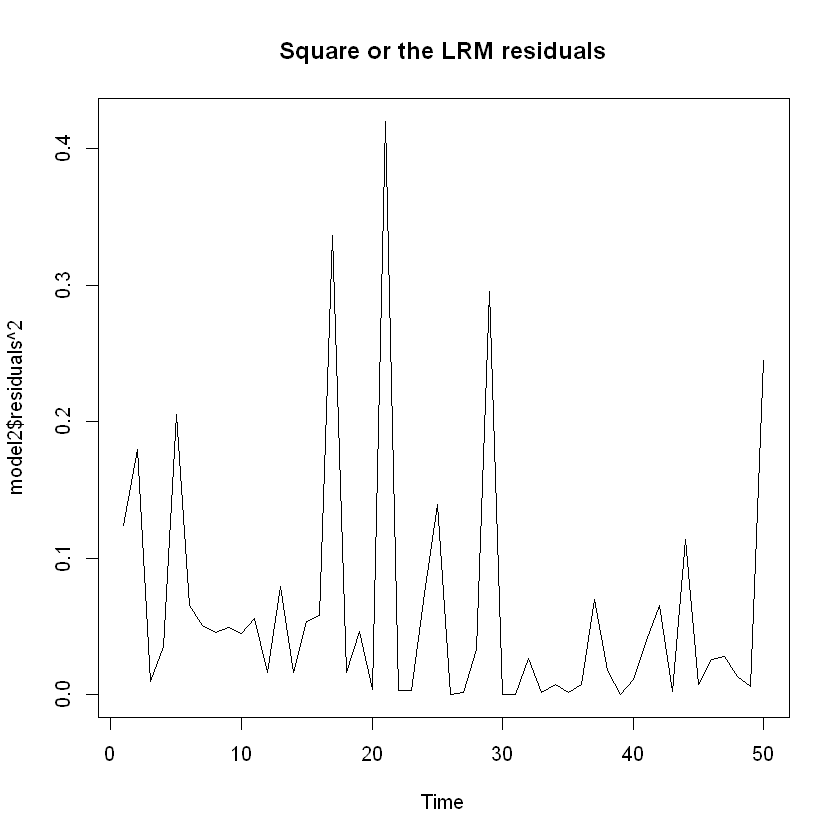

In [48]:
ts.plot(model2$residuals^2)
title('Square or the LRM residuals')

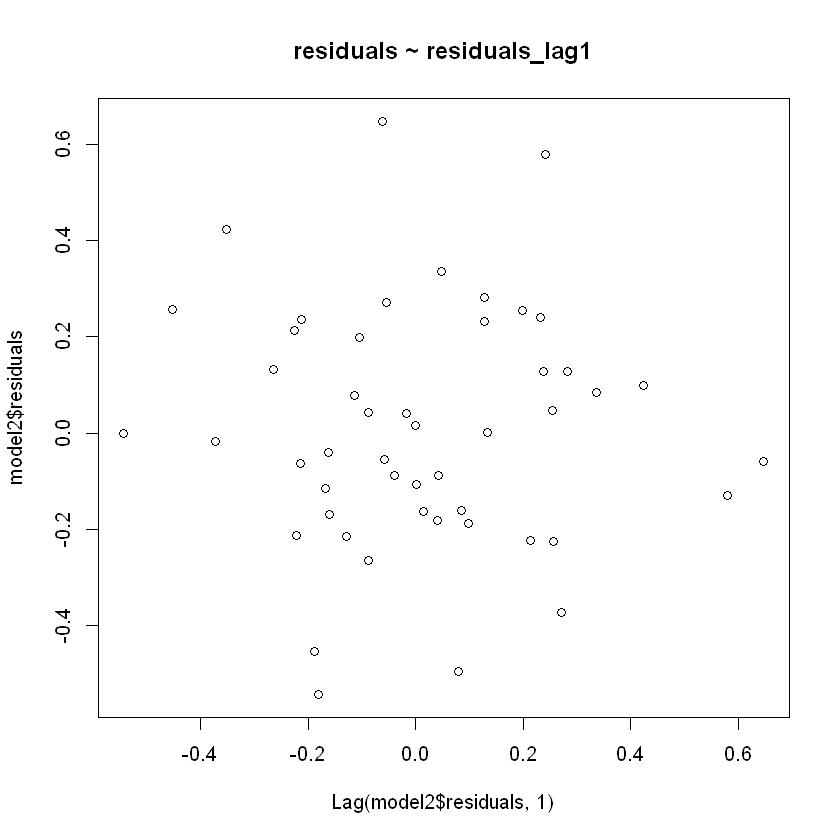

In [49]:
plot(x = Lag(model2$residuals, 1), y = model2$residuals )
title('residuals ~ residuals_lag1')

The first plot gives us preliminary evidence that it seems that the variance of the residuals are a function of time, which implies that A2a was violated. 

In the second plot we can see that theres no relationship between the residuals and its first lag, which means that we dont have any evidence that A2b was violted.

Further tests must be made.

#### Goldfeld-Quandt (1965) test
Assume that we have a sample of size T. The Goldfeld-Quandt test consists in splitting the sample into two parts, T1 and T2. The linear regression model is estimated in each of the samples, and the residual variances are calulated. 

The hypothesis of the test is as follows:

$
H_0: \sigma^2_1 = \sigma^2_2 \\
H_1: \sigma^2_1 \neq \sigma^2_2
$

The test statistics, denoted GQ, is given by:

$
GQ = \frac{max(s^2_1, s^2_2)}{min(s^2_1, s^2_2)}
$

Where:

$
s^2_1 = \frac{\hat{u}^{'}_1\hat{u}_1}{T_1-k} \quad s^2_2 = \frac{\hat{u}^{'}_2\hat{u}_2}{T_2-k} 
$

Under the null hypothesis we have that:

$
GQ \sim F(T_1-k, T_2-k)
$


In [50]:
# model2 = lm(y ~ ipr + su + sr, data = df_est)
gqtest(df$y ~ df$ipr + df$su + df$sr, alternative = 'two.sided')


	Goldfeld-Quandt test

data:  df$y ~ df$ipr + df$su + df$sr
GQ = 0.99865, df1 = 31, df2 = 31, p-value = 0.997
alternative hypothesis: variance changes from segment 1 to 2


The p-value of the test does not give us evidence that the variance across the two samples have changed. Therefore, we do not reject the null hypothesis.

#### Breusch-Pagan-Godfrey test
Their approach seeks to test whether the variance of the residuals are a linear function of a set of variables $Z$, where $Z$ could be equal to the independent variables. To do that, we need to first fit a LRM using the OLS estimator, than we regress the square of the residuals against $Z$, finally we calculate the test statistics that is a function of the second regression $R^2$.

The hypothesis of the test is as follows:

$
H_0: \sigma^2_t = \sigma^2 \\
H_1: \sigma^2_t = \gamma + \delta Z_t
$

The test statistics, denoted GQ, is given by:

$
BPG = TR^2
$

Under the null hypothesis we have that:

$
BPG \sim \chi^2(k)
$

where $k$ is the number of regressors.

In [51]:
bptest(model2)


	studentized Breusch-Pagan test

data:  model2
BP = 2.2395, df = 3, p-value = 0.5242


Again, the test does not provide us evidence that the homoskedasticity assumtion has beem violated.

#### White (1980) test
The white test consists of a two-step procedure. First estimate a linear regression model (assuming two independent variables):

$
y_t = \beta_1 + \beta_2 x_{2,t} + \beta_3 x_{3,t} + u_t
$

Second, run the auxiliary regression model given by:

$
\hat{u}^2_t = \alpha_1 + \alpha_2 x_{2,t} + \alpha_3 x_{3,t} + \alpha_4 x^2_{2,t} + \alpha_5 x^2_{3,t} + \alpha_6 x_{2,t}x_{3,t} + v_t
$

The hypothesis of the test is as follows:

$
H_0: \sigma^2_t = \sigma^2 \\
H_1: \sigma^2_t = \mathcal{f}(X_t, Z_t)
$

where $Z_t$ are interactions between the independent variables.

The test statistics, denoted W, is given by:

$
W = TR^2
$

Under the null hypothesis we have that:

$
W \sim \chi^2(k)
$

In [52]:
residuals2_squared = (model2_full$residuals)^2
ipr_squared = df$ipr^2
su_squared = df$su^2
sr_squared = df$sr^2
df2 = cbind(df, residuals2_squared, ipr_squared, su_squared, sr_squared)
model2_white_adj = lm(residuals2_squared ~ ipr + su + sr + ipr_squared + su_squared + sr_squared, data = df) 

The model statistics shows that there is no evidence that any of the regressors or its interations are significative to explain the square of the residuals. Therefore, we do not reject the null hypothesis.

#### Durbin-Watson test

The hypothesis of the test is as follows:

$
H_0: \epsilon_t \quad uncorrelated \\
H_1: \epsilon_t = \rho\epsilon_{t-1} + u_t
$

The test statistics is based on the OLS residuals and is given by:

$
DW = \frac{\sum_{t=2}^{T}(\hat{\epsilon}_t-\hat{\epsilon}_{t-1})^2}{\sum_{t=1}^{T}\hat{\epsilon}^2_t}
$

In [58]:
dwtest(model2_full)


	Durbin-Watson test

data:  model2_full
DW = 1.4337, p-value = 0.004866
alternative hypothesis: true autocorrelation is greater than 0


In [ ]:
Given the p-value of the regression, we have strong evidence to reject the null of uncorrelated error terms.

#### Breusch-Godfrey test

The hypothesis of the test is as follows:


$H_0$: $\epsilon_t$ is uncorrelated 

$H_1$: $\epsilon_t$ is correlated up to order m
$

The test statistics is also based on the OLS residuals and is given by:

$
LM = T(\sum_{j=1}^{m}r^2_j) \quad where \quad r_j = \frac{\sum_{t=j+1}^{T}(\hat{\epsilon}_t-\hat{\epsilon}_{t-1})^2}{\sum_{t=1}^{T}\hat{\epsilon}^2_t}
$

Under the null hypothesis the LM statistics has a $\chi^2(m)$ distribution.

In [60]:
bgtest(model2_full)


	Breusch-Godfrey test for serial correlation of order up to 1

data:  model2_full
LM test = 5.0031, df = 1, p-value = 0.0253


In line with the Durbin-Watson test, the LM statistics provide us evidence that we can reject the null of uncorrelated errors

## (ii) Apply heteroskedasticity robust methods + corrections


#### Generalized least squares estimator (GLS)

One convenient way to define heteroskedasticity is as follows. Let $\Omega$ be the positive definite covariance matrix of the residuals. Since $\Omega$ is positive definite, the following deocmposition is possible:

$
H \Omega H^{'} = \mathbf{I} \Leftrightarrow \Omega = H^{-1}(H^{'})^{-1} = (H^{'}H)^{-1}
$

In particular, for a heteroskedastic process and assuming T=3 we have:

$
H = 
\begin{bmatrix}
1/\sigma^2_1 & 0 & 0\\
0 & 1/\sigma^2_2 & 0\\
0 & 0 & 1/\sigma^2_T
\end{bmatrix}
$

One way to correct for heteroskedastic error terms is to derive the GLS estimator, which is robust to structure on the variance covariance matrix of the errors. Recall the LRM and apply the variance decomposition showed before:

$
\mathbf{y} = X\mathbf{\beta} + \mathbf{\epsilon} \Leftrightarrow H\mathbf{y} = H X\mathbf{\beta} + H\mathbf{\epsilon} \Leftrightarrow \tilde{Y} = \tilde{X}\mathbf{\beta} + \tilde{\mathbf{\epsilon}}
$

where

$
\mathbf{E}[\tilde{\mathbf{\epsilon}}\tilde{\mathbf{\epsilon}}^{'}] = H \Omega H^{'} = \mathbf{I}
$

It is possible to show that the resulting adjusted OLS estimator, namely GLS estimator, is given by:

$
\hat{\beta}_{GLS} = (\tilde{X}^{'}\tilde{X})^{-1}\tilde{X}^{'}\tilde{Y} = (X^{'}\Omega^{-1}X)^{-1}X^{'}\Omega^{-1}Y
$

The GLS estimator is BLUE in the presence of heteroskedasticity.

In [55]:
model2_full_gls = gls(y ~ ipr + su + sr, df)
summary(model2_full_gls)

Generalized least squares fit by REML
  Model: y ~ ipr + su + sr 
  Data: df 
       AIC      BIC    logLik
  58.26314 69.21142 -24.13157

Coefficients:
                 Value  Std.Error   t-value p-value
(Intercept)  0.2694644 0.03602064  7.480834  0.0000
ipr          0.3255164 0.02786254 11.682939  0.0000
su          -0.0291289 0.01470688 -1.980631  0.0518
sr           0.0096267 0.00508870  1.891783  0.0629

 Correlation: 
    (Intr) ipr    su    
ipr -0.201              
su   0.234 -0.645       
sr  -0.181  0.052 -0.543

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.18213870 -0.63740564 -0.06395407  0.66838544  2.48615612 

Residual standard error: 0.2905255 
Degrees of freedom: 70 total; 66 residual

In [56]:
summary(model2_full)


Call:
lm(formula = y ~ ipr + su + sr, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63397 -0.18518 -0.01858  0.19418  0.72229 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.269464   0.036021   7.481 2.25e-10 ***
ipr          0.325516   0.027863  11.683  < 2e-16 ***
su          -0.029129   0.014707  -1.981   0.0518 .  
sr           0.009627   0.005089   1.892   0.0629 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2905 on 66 degrees of freedom
Multiple R-squared:  0.7959,	Adjusted R-squared:  0.7866 
F-statistic: 85.77 on 3 and 66 DF,  p-value: < 2.2e-16


Since our previous test did not suppot the hypothesis of heteroskedasticity in the error terms, we expect that the OLS and GLS estimates should be the same. This is what the above summaries shows.

#### Heteroskedasticity and Autocorrelation Consistent variance estimators (HAC)

Another way to adjust your estimates in the presence of heteeroskedasticity is to use the HAC variance estimator. This procedure consists of estimating the LRM parameters using the OLS estimator and than adjusting the stnadard error estimates.


#### (c) Parameter instability

It is possible to add a sixth hypothesis to the LRM, which is:

> A6. The parameters are stable acoss time, that is, $\beta_{it} = \beta_i$

We now consider a violation of this hypothesis. Lets re-write the LRM with timevarying coefficients:

$
\mathbf{y}_t = X_{1t}\mathbf{\beta}_{1t} + ... + X_{kt}\mathbf{\beta_{kt}} + \mathbf{\epsilon}_t
$

If we by mistake have represented the parameters as constant, the OLS estimator in the sample period will be biased and inconsistent. Furthermore, mis-representation will also induce bias in the forecasst sample.

#### (i) Tests for parameter instability

#### Chow test

Assume that we splitted a sample o size $T$ into $T_1$ and $T_2$. Let us consider the following set of hypothesis:

$
H_0: H^{'}_0 \cup H^{''}_0 \quad where \quad H^{'}_0: \beta_1 = \beta_2 \quad and \quad H^{''}_0: \sigma^2_1 = \sigma^2_2\\
H_1: H^{'}_1 \cup H^{''}_1 \quad where \quad H^{'}_1: \beta_1 \neq \beta_2 \quad and \quad H^{''}_1: \sigma^2_1 \neq \sigma^2_2\\
$

If $T_2 > k$, the procedure is to estimate three models, one in the whole sample $T$, another in the first sample $T_1$, and finally the last one in the sample $T_2$. Let $RSS_j$ be the sum of the squared residuals, where $j \in \{T, T_1, T_2\}$, then the Chow test is given by:

$
CH_1 = (\frac{RSS_T - RSS_{T_1} - RSS_{T_2}}{RSS_{T_1} + RSS_{T_2}}) \frac{T-2k}{k}
$

Under the null we have that $CH_1 \sim F(k, T-2k)$.

The argument of the test is that, if the parameters are stable between samples, then $RSS_T$ will probably be close to $RSS_{T_1} + RSS_{T_2}$, otherwise the paremeters will be unstable.


In [65]:
sctest(y ~ ipr + su + sr, data = df, type = 'Chow', from = 50, to = 55)


	Chow test

data:  y ~ ipr + su + sr
F = 2.2577, p-value = 0.07296


Despite the statistics of the Chow test been greater than the typicall significance level used on empirical research (0.05), it tell us that we have a low probability of type I error. Its wise to require further tests to reject the hypothesis of parameter instability.

#### Chow forecast test

In [68]:
chow.test(df_est$y, cbind(df_est$ipr, df_est$su, df_est$sr), df_fore$y, cbind(df_fore$ipr, df_fore$su, df_fore$sr))

F value        d.f.1        d.f.2      P value 
7.030271e+00 4.000000e+00 6.200000e+01 9.835943e-05

#### Recursive forecast test for parameter instability

The strategy here is recursevevly estimate the OLS estimator and plot it in time. If $\beta$ is constant over time, then $\hat{\beta}_t$ should quickly settle down to a common value.


In [ ]:
#>> **(ii)** Forecast with/without dummy variables + batch and recursive method

In [53]:
model2_D = lm(y ~ D2000s +  ipr + su + sr + D2000s*ipr + D2000s*su + D2000s*sr, data = df_est)
summary(model2_D)


Call:
lm(formula = y ~ D2000s + ipr + su + sr + D2000s * ipr + D2000s * 
    su + D2000s * sr, data = df_est)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54848 -0.14816  0.02646  0.16432  0.50730 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.306385   0.053538   5.723 9.94e-07 ***
D2000s       0.523145   0.205147   2.550   0.0145 *  
ipr          0.396918   0.072041   5.510 2.01e-06 ***
su          -0.014864   0.023049  -0.645   0.5225    
sr           0.004526   0.005252   0.862   0.3937    
D2000s:ipr  -0.474532   0.198359  -2.392   0.0213 *  
D2000s:su    0.124518   0.079825   1.560   0.1263    
D2000s:sr   -0.002443   0.018223  -0.134   0.8940    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.244 on 42 degrees of freedom
Multiple R-squared:  0.6102,	Adjusted R-squared:  0.5452 
F-statistic: 9.393 on 7 and 42 DF,  p-value: 5.933e-07


In [64]:
predit_model2_df = as.data.frame(cbind(df_est$ipr, df_est$su, df_est$sr))
colnames(predit_model2_df) = c('ipr', 'su', 'sr')
predit_model2_D_df = as.data.frame(cbind(df_est$D2000s, df_fore$ipr, df_fore$su, df_fore$sr,
                                       df_fore$ipr*df_est$D2000s, df_fore$su*df_est$D2000s,
                                       df_fore$sr*df_est$D2000s))
colnames(predit_model2_D_df) = c('D2000s', 'ipr', 'su', 'sr', 'D2000s:ipr', 'D2000s:su', 'D2000s:sr')

Warning message in df_fore$ipr * df_est$D2000s:
"longer object length is not a multiple of shorter object length"Warning message in df_fore$su * df_est$D2000s:
"longer object length is not a multiple of shorter object length"Warning message in df_fore$sr * df_est$D2000s:
"longer object length is not a multiple of shorter object length"Warning message in cbind(df_est$D2000s, df_fore$ipr, df_fore$su, df_fore$sr, df_fore$ipr * :
"number of rows of result is not a multiple of vector length (arg 2)"

In [66]:
head(predit_model2_D_df)

D2000s,ipr,su,sr,D2000s:ipr,D2000s:su,D2000s:sr
0,-2.100427,-6.718558,-13.790570,0,0,0
0,-7.230932,-15.587466,-30.456952,0,0,0
0,-10.195336,-11.041747,-13.169687,0,0,0
0,-1.173034,4.768213,9.637599,0,0,0
0,2.332467,11.190226,11.556131,0,0,0
0,1.325365,8.763899,7.976892,0,0,0


In [67]:
yhat = list()
yhat$y = predict(model2, newdata = predit_model2_df) # no dummy
yhat$yD = predict(model2_D, newdata = predit_model2_D_df) # with dummy

yhat$yD.se = sqrt(sum(model2_D$residuals^2) / 198)
yhat$yD.up = yhat$yD + 1.96 * yhat$yD.se
yhat$yD.low = yhat$yD - 1.96 * yhat$yD.se

In [69]:
yhat.plot <- data.table('yhat' = rbindlist(list(data.table(df_fore$y),
                                                data.table(yhat$y),
                                                data.table(yhat$yD))),
                        'label' = rep(c('Y', 'YHAT_OLS', 'YHAT_OLSD'), each = 100))

#ggplot(yhat.plot, aes(x = rep(302:401, 3), y = yhat.plot$yhat.V1, linetype = label)) +
#  geom_line() + xlab('') + ylab('') + theme(legend.title = element_blank()) 

Warning message in data.table(yhat = rbindlist(list(data.table(df_fore$y), data.table(yhat$y), :
"Item 1 is of size 120 but maximum size is 300 (recycled leaving remainder of 60 items)"

In [72]:
yhat_plot_df = cbind(df_fore$y, yhat$y,yhat$yD)
colnames(yhat_plot_df) = c('Y', 'YHAT_OLS', 'YHAT_OLSD')
head(yhat_plot_df)

Warning message in cbind(df_fore$y, yhat$y, yhat$yD):
"number of rows of result is not a multiple of vector length (arg 1)"

Y,YHAT_OLS,YHAT_OLSD
-0.6150647,0.3328780,-0.4898642
-1.7245239,0.3463290,-2.4698597
-2.8802190,0.4465504,-3.6358107
-0.2804189,0.4955662,-0.1864682
0.3952763,0.8020182,1.1181558
0.4471209,0.9948748,0.7382839


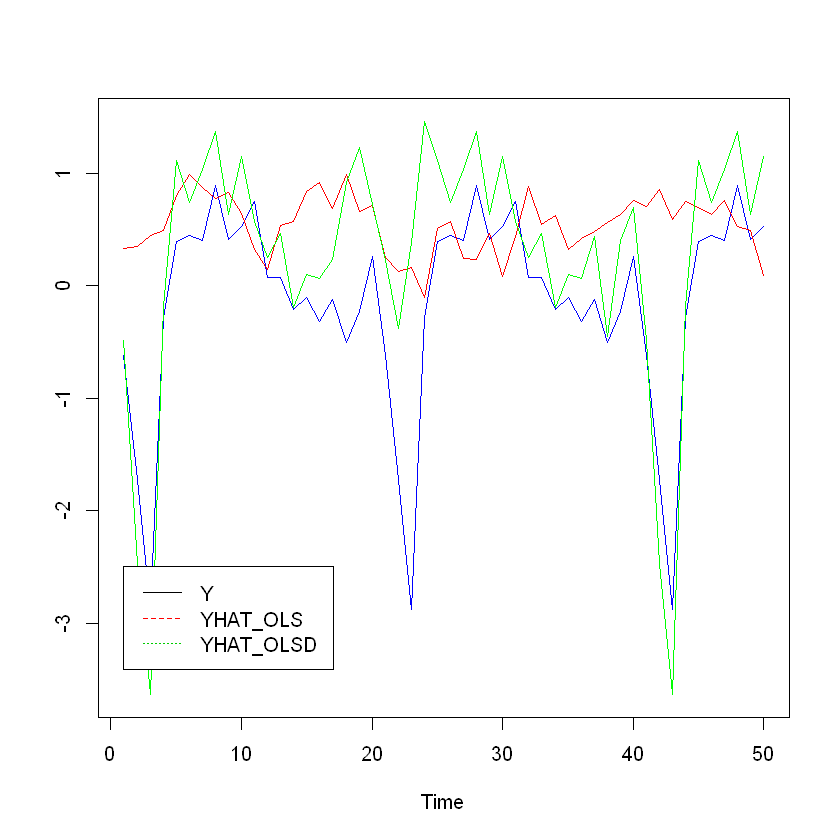

In [86]:
ts.plot(yhat_plot_df, col=c("blue", "red", "green"))
legend(1, -2.5, c("Y", "YHAT_OLS", "YHAT_OLSD"), col = 1:3, lty = 1:3)

In [94]:
df = as.data.frame(cbind(df_orig$ipr, df_orig$su, df_orig$sr))
colnames(df) = c('ipr', 'su', 'sr')
df_y = as.data.frame(cbind(df_orig$y, df_orig$ipr, df_orig$su, df_orig$sr))
colnames(df_y) = c('y', 'ipr', 'su', 'sr')

df_D = as.data.frame(cbind(df_orig$D2000s, df_orig$ipr, df_orig$su, df_orig$sr,
                                       df_orig$ipr*df_orig$D2000s, df_orig$su*df_orig$D2000s,
                                       df_orig$sr*df_orig$D2000s))
colnames(df_D) = c('D2000s', 'ipr', 'su', 'sr', 'D2000s:ipr', 'D2000s:su', 'D2000s:sr')

df_D_y = as.data.frame(cbind(df_orig$y, df_orig$D2000s, df_orig$ipr, df_orig$su, df_orig$sr,
                                       df_orig$ipr*df_orig$D2000s, df_orig$su*df_orig$D2000s,
                                       df_orig$sr*df_orig$D2000s))
colnames(df_D_y) = c('y', 'D2000s', 'ipr', 'su', 'sr', 'D2000s:ipr', 'D2000s:su', 'D2000s:sr')


In [135]:
y_real = list()
for (i in (dim(df_orig)[1]/2):(dim(df_orig)[1]-1)) {
    ols.rec = lm(y ~ ipr + su + sr, data = df_y[1:i,])
    yhat$y.rec[i] = predict(ols.rec, newdata = df_orig[i + 1,])
    y_real[i] = df_y$y[i+1]

    olsD.rec = lm(y ~ D2000s +  ipr + su + sr + D2000s*ipr + D2000s*su + D2000s*sr, data = df_D_y[1:i,])
    yhat$yD.rec[i] <- predict(olsD.rec, newdata = df_D[i + 1,])
    #yhat$yD.recse[i] <- sqrt(sum(olsD.rec$residuals^2) / (197 + i))
}

In [126]:
library(DataCombine)

Warning message:
"package 'DataCombine' was built under R version 3.6.3"
Attaching package: 'DataCombine'

The following object is masked from 'package:data.table':

    shift



In [149]:
yhay_rec_df = cbind(y_real, yhat$y.rec, yhat$yD.rec) %>% as.data.frame() %>% drop_na()
colnames(yhay_rec_df) = c('y_real', 'yhat_rec', 'yhatD_rec')

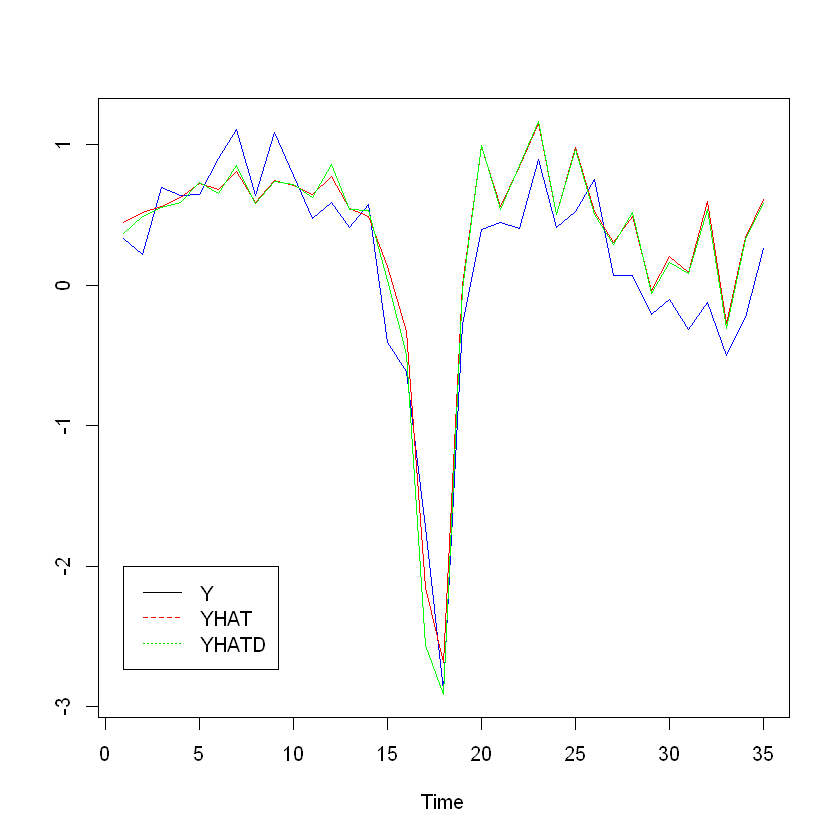

In [151]:
ts.plot(yhay_rec_df, col=c("blue", "red", "green"))
legend(1, -2, c('Y',"YHAT", "YHATD"), col = 1:3, lty = 1:3)